# Audubon Park Land Encroachment

During my walks in audubon park I have noticed a concerning trend.  It appears at least to me that homeowners are appropriating the public parks intended for all of us to use for the own benefit.  The main vehicle for this appropriation seems to be adding in landscaping which acts as a barrier.  Typically cast-iron or bambo.  This is my attempt to figure whats going on

#### Datasets
* Parcel Map:  https://data.nola.gov/dataset/Parcels/v9q5-fz7t



In [1]:
import geopandas as gpd
#import contextily as cx

import pandas as pd
import numpy as np

import shapely
import shapely.geometry

import geoplot.crs as gcrs
import geoplot as gplt
#import plotly

import folium
#import fiona
import matplotlib.pyplot as plt

import pyproj

In [2]:
useCRS = 'EPSG:4326'
precisionCRS = 'EPSG:32615'

In [3]:
makePrec = pyproj.Proj(proj='utm', zone=15, ellps='WGS84', preserve_units=True)

In [4]:
parcelsGpd = gpd.read_file('./datasets/Parcels.geojson')

In [5]:
parcelsGpd = parcelsGpd.to_crs(useCRS)

In [6]:
parcelsGpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
#drop public property
parcelsGpd = parcelsGpd[ parcelsGpd['situs_street'] != 'Calhoun' ].copy()  #some kind of public property idk

In [8]:
parcelsGpd.head(3)

,situs_dir,acres,geopin,perimeter,situs_street,objectid,situs_number,situs_type,shape_stlength,shape_starea,geometry
0,None,2.33144428,41000085,1274.88858944,Teche,8,1550,St,1274.8885894439447,101557.7126865364,"MULTIPOLYGON (((-90.05297 29.94002, -90.05194 ..."
1,None,2.53462307,41000073,1329.79083901,None,7,None,None,1329.7908390045563,110408.18073966558,"MULTIPOLYGON (((-90.04962 29.93506, -90.05003 ..."
2,None,1.50430764,41000121,1709.61143124,None,13,None,None,1709.6114312296079,65527.640857487393,"MULTIPOLYGON (((-90.03553 29.93058, -90.03586 ..."


In [9]:
#hehe get it
audoBounds = [
    (-90.12709, 29.93416),
    (-90.12624, 29.93376),
    (-90.13127, 29.92649),
    (-90.13223, 29.92693),
    
    
]

audoBounds.append(audoBounds[0])

POLYGON ((-90.12709 29.93416, -90.12624 29.93376, -90.13127 29.92649, -90.13223 29.92693, -90.12709 29.93416))


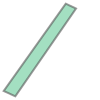

In [10]:
audoBoundsShape = shapely.geometry.Polygon([shapely.geometry.Point(*pt) for pt in audoBounds])
print(audoBoundsShape)

audoBoundsShape

In [11]:
audoBoundsShapeGS_wgs84 = gpd.GeoSeries(audoBoundsShape, crs='WGS84')
audoBoundsShapeGS = audoBoundsShapeGS_wgs84.to_crs(useCRS)

In [12]:
audoHousesMask = parcelsGpd['geometry'].intersects(audoBoundsShapeGS.iloc[0])

(np.count_nonzero(audoHousesMask), parcelsGpd.shape[0])


(36, 150935)

In [13]:
audubonCenter = shapely.geometry.box( *parcelsGpd[audoHousesMask].total_bounds ).centroid
list(audubonCenter.coords)[0]

(-90.128358945389, 29.925792067494)

<GeoAxesSubplot:>

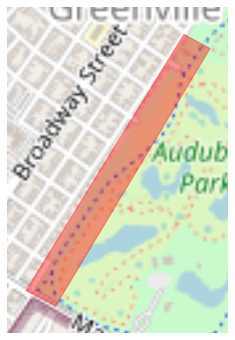

In [14]:
proj = gcrs.WebMercator()

ax = gplt.webmap(audoBoundsShapeGS, projection=proj, zoom=14)
gplt.polyplot(audoBoundsShapeGS, ax=ax, color='r', alpha=0.4 )



In [15]:
m = folium.Map(location=(audubonCenter.y,audubonCenter.x), zoom_start=16)

folium.Choropleth(geo_data=audoBoundsShapeGS, fill_color='red').add_to(m)

print("Target bounds (The area of investigation)")

m

Target bounds (The area of investigation)


In [16]:
audubonPark = parcelsGpd[audoHousesMask].loc[parcelsGpd[audoHousesMask]['situs_number'] == '501']
privateProperties = parcelsGpd[audoHousesMask][parcelsGpd[audoHousesMask]['situs_number'] != '501']

In [17]:
privateProperties['geometry'] = privateProperties['geometry'].map(lambda g:  shapely.ops.unary_union( g.geoms ) )

<GeoAxesSubplot:>

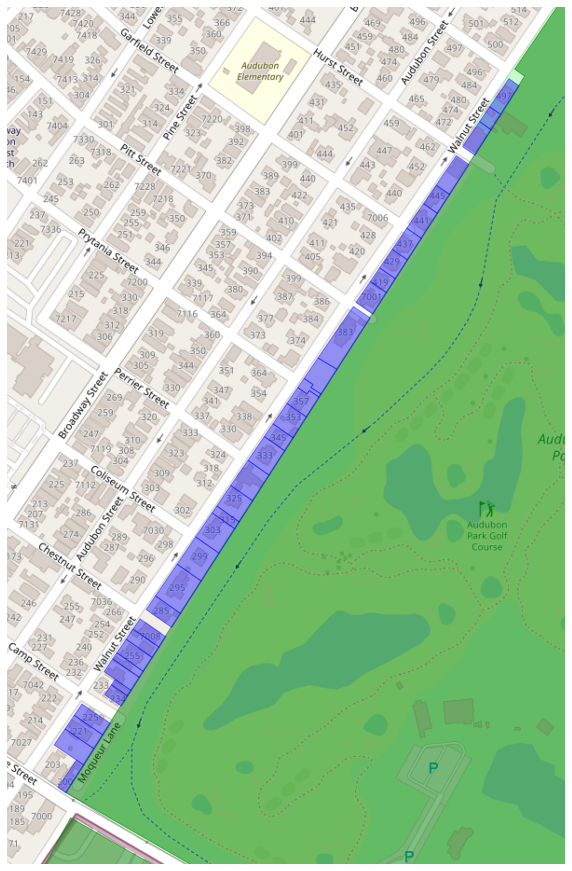

In [18]:
proj = gcrs.WebMercator()

fig, ax = plt.subplots(1, figsize=(10,20), subplot_kw={'projection':proj})
                       
                       

gplt.webmap(privateProperties,ax=ax)
gplt.polyplot(audubonPark, ax=ax, color='g', alpha=0.5 )
gplt.polyplot(privateProperties, ax=ax, color='b', alpha=0.4 )


In [19]:
def getEast(shape):
    coords = list(shape.exterior.coords)
    
    output = (-500,-500)
    
    for coord in coords:
        if coord[0] > output[0]:
            output = coord
            
    return shapely.geometry.Point( output )
    
privateProperties['EastCorner'] = gpd.GeoSeries( privateProperties['geometry'].map(getEast), crs='WGS84' )

In [20]:
def getSouth(shape):
    coords = list(shape.exterior.coords)
    
    output = (500,500)
    
    for coord in coords:
        if coord[1] < output[1]:
            output = coord
            
    return shapely.geometry.Point( output )
    
privateProperties['SouthCorner'] = gpd.GeoSeries( privateProperties['geometry'].map(getSouth), crs='WGS84' )

In [21]:
def getPropLine(row):
    return shapely.geometry.LineString([row['SouthCorner'], row['EastCorner']])

privateProperties['PropLine'] = gpd.GeoSeries( privateProperties.apply(getPropLine, axis=1), crs='WGS84')

C:\Users\gbezet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [22]:
print("SouthCorners")

def checkCorners(col='EastCorner'):
    m = folium.Map(location=(audubonCenter.y,audubonCenter.x), zoom_start=16)

    folium.Choropleth(geo_data=audubonPark, fill_color='green').add_to(m)
    folium.Choropleth(geo_data=privateProperties['geometry'], fill_color='blue').add_to(m)



    for idx, row in privateProperties.iterrows():
        popup = f"South West Corner of {row['situs_number']} {row['situs_street']} {row['situs_type']}"
        folium.Marker(location=[row[col].y,row[col].x], popup=popup, \
                      icon=folium.Icon(color="red"), \
                      ).add_to(m)


    return m

checkCorners('SouthCorner')

SouthCorners


In [109]:

#WGS84 causes some caused the angles to be off.
def getPenaltyBox(row):

    pt1 =  np.array( makePrec(*row['SouthCorner'].xy)  ).reshape(2,)
    pt2 = np.array(  makePrec(*row['EastCorner'].xy)   ).reshape(2,)

    precisionLine = shapely.geometry.LineString( [pt1,pt2] )
    penalityLine = precisionLine.parallel_offset( 30 )
    
    penalityLineWGS84 = makePrec(*penalityLine.xy, inverse = True)
        
    pts = [ shapely.geometry.Point(penalityLineWGS84[0][idx],penalityLineWGS84[1][idx]) for idx in range(len(penalityLineWGS84[0]))]
    
    pts.append(row['SouthCorner'])
    pts.append(row['EastCorner'])
    
    return shapely.geometry.Polygon(pts)
    
    


privateProperties['PenalityBox'] = privateProperties.apply(getPenaltyBox, axis=1)


<GeoAxesSubplot:>

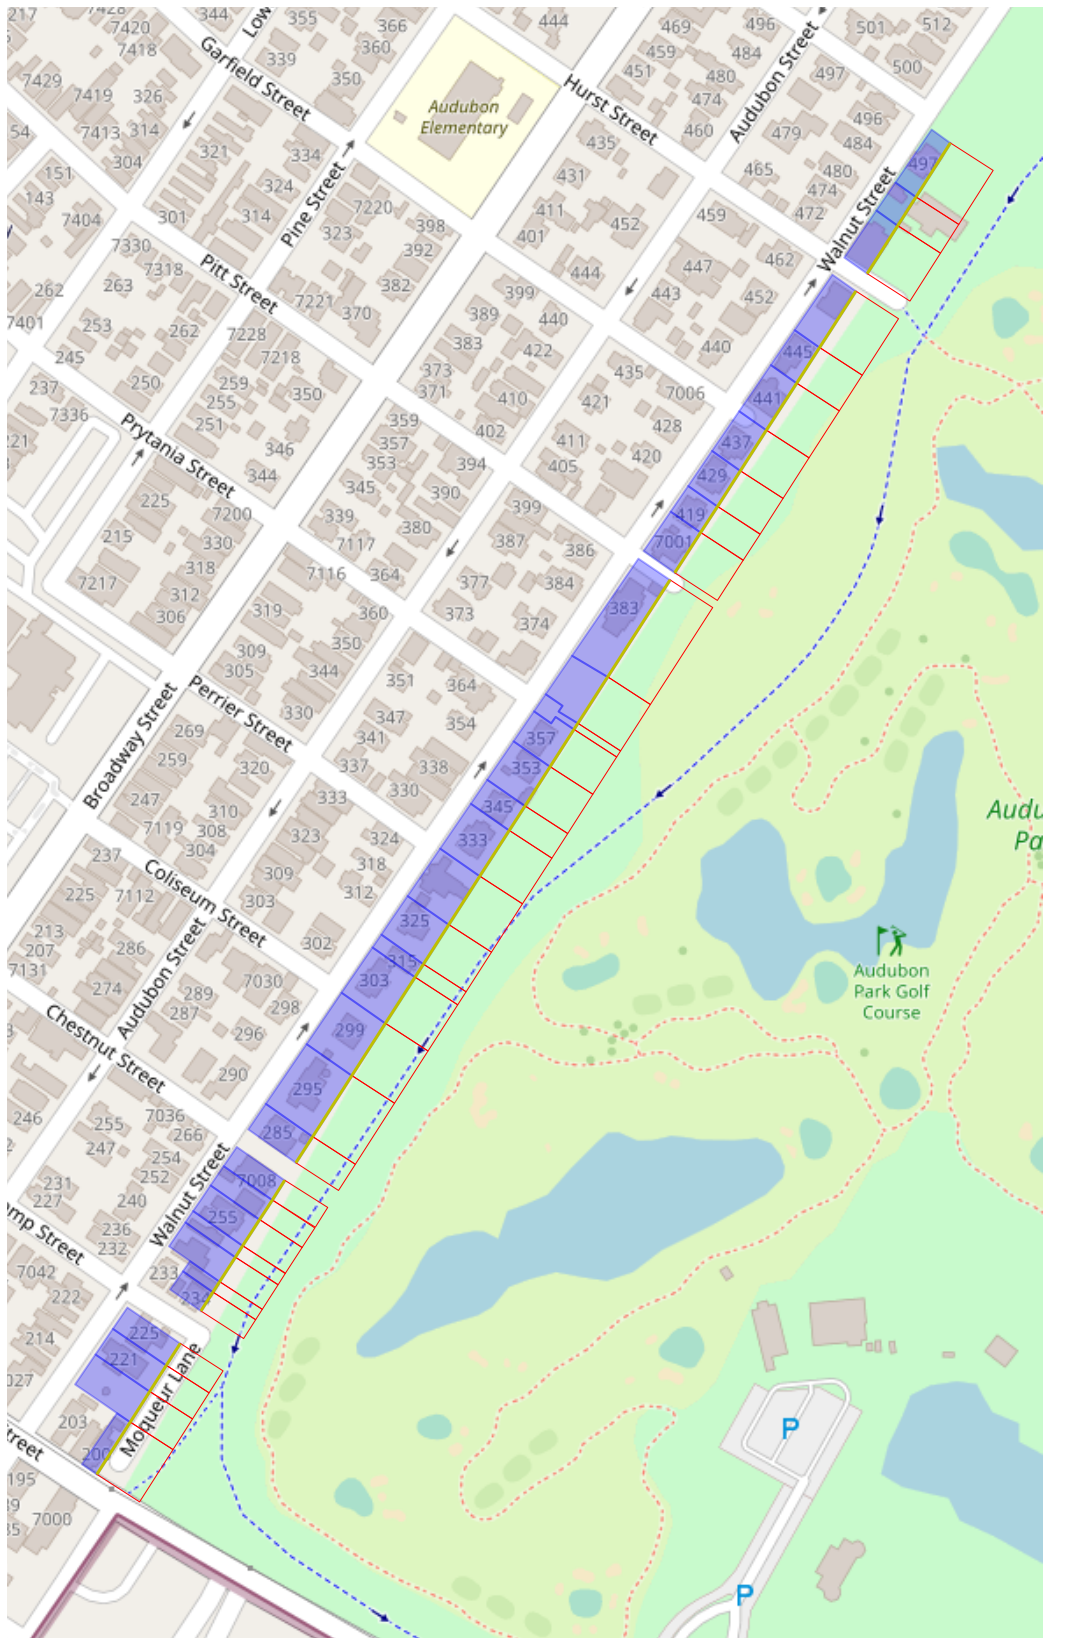

In [117]:
fig,ax=plt.subplots(figsize=(20,30),subplot_kw={'projection': gplt.WebMercator()})

#ax.set(projection=gplt.WebMercator())

gplt.webmap(privateProperties, ax=ax)

gplt.polyplot(privateProperties, color='blue', edgecolor='blue', ax=ax, alpha=0.3, linewidth=2, label='Property Parcel')


gplt.sankey(privateProperties['PropLine'], ax=ax, linewidth=3,color='y', label='Property Line with Audubon Park')

gplt.polyplot(privateProperties['PenalityBox'], ax=ax, edgecolor='r', label='Area of assume responsibility for property')


